# PyTorch 基本介紹（含 code demo）

[搭配投影片](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML2020/PyTorch_Introduction.slides.html#/23)

In [ ]:
#@markdown （請先記得將 Colab 硬體 runtime 調成 GPU 模式喔！）  

#@markdown 先下載等等需要的 data 
#@markdown ###（**_記得 run 我！_**）

%%bash
wget -q -N https://download.pytorch.org/tutorial/faces.zip
if [ ! -d data ]; then mkdir data; fi
unzip -q -o faces.zip -d data
rm -f faces.zip

#### 載入需要的 libraries （函式庫）

In [ ]:
import os

import numpy as np
import pandas as pd

# 深度學習套件
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# 作圖套件
import matplotlib.pyplot as plt

# 影像處理套件
import torchvision.transforms as transforms
from skimage import io, transform

◉ 為了可以 reproduce (重現)，最好固定住 random seed

In [ ]:
torch.manual_seed(446)
np.random.seed(446)

## Tensor（張量）和 Numpy array 的關係與互相轉換

In [ ]:
# we create tensors in a similar way to numpy nd arrays
x_numpy = np.array([0.1, 0.2, 0.3])
x_torch = torch.tensor([0.1, 0.2, 0.3])
print('x_numpy, x_torch')
print(x_numpy, x_torch)
print()

# to and from numpy, pytorch
print('to and from numpy and pytorch')
print(torch.from_numpy(x_numpy), x_torch.numpy())
print()

# we can do basic operations like +-*/
y_numpy = np.array([3,4,5.])
y_torch = torch.tensor([3,4,5.])
print("x+y")
print(x_numpy + y_numpy, x_torch + y_torch)
print()

# many functions that are in numpy are also in pytorch
print("norm")
print(np.linalg.norm(x_numpy), torch.norm(x_torch))
print()

# to apply an operation along a dimension,
# we use the dim keyword argument instead of axis
print("mean along the 0th dimension")
x_numpy = np.array([[1,2],[3,4.]])
x_torch = torch.tensor([[1,2],[3,4.]])
print(np.mean(x_numpy, axis=0), torch.mean(x_torch, dim=0))

x_numpy, x_torch
[0.1 0.2 0.3] tensor([0.1000, 0.2000, 0.3000])

to and from numpy and pytorch
tensor([0.1000, 0.2000, 0.3000], dtype=torch.float64) [0.1 0.2 0.3]

x+y
[3.1 4.2 5.3] tensor([3.1000, 4.2000, 5.3000])

norm
0.37416573867739417 tensor(0.3742)

mean along the 0th dimension
[2. 3.] tensor([2., 3.])


### **`Tensor.view`**  
改變 tensor 的 shape （形狀、各維度大小），類似於 `numpy.reshape()`  
可以傳入一個 `-1` 表示不固定的維度（會根據資料數量計算，無法整除會出錯提醒）

In [ ]:
# "MNIST"
N, C, W, H = 10000, 3, 28, 28
X = torch.randn((N, C, W, H))

print(X.shape)
print(X.view(N, C, 784).shape)
print(X.view(-1, C, 784).shape) # automatically choose the 0th dimension

torch.Size([10000, 3, 28, 28])
torch.Size([10000, 3, 784])
torch.Size([10000, 3, 784])


### Computation graphs （計算圖）
將 tensor 的計算用 graph 表示  
<img src="https://i.imgur.com/KuiL6qo.png" height="320px"/>  
以下計算 $e=(a+b)\times(b+1)$  
其中 $a=2, b=1$

In [ ]:
a = torch.tensor(2.0, requires_grad=True) # we set requires_grad=True to let PyTorch know to keep the graph
b = torch.tensor(1.0, requires_grad=True)
c = a + b
d = b + 1
e = c * d
print('c', c)
print('d', d)
print('e', e)

c tensor(3., grad_fn=<AddBackward0>)
d tensor(2., grad_fn=<AddBackward0>)
e tensor(6., grad_fn=<MulBackward0>)


## 將 PyTorch 用作自動求導框架
由於在進行深度學習時經常需要取 gradient （梯度、導函數、微分），以下示範對函數進行求導的過程

考慮函數 $f(x) = (x-2)^2$
我們來計算 $f(x)$ 對 $x$ 在 $x = 1$ 時的微分，也就是求 $f'(1)$

使用 `backward()` 可以自動對 leaf variable（計算圖上的 leaf）取微分（詳見課程 **back propagation**)


In [ ]:
def f(x):
    return (x-2)**2

def fp(x):
    return 2*(x-2)

x = torch.tensor([1.0], requires_grad=True)

y = f(x)
y.backward()

print('Analytical f\'(x):', fp(x))
print('PyTorch\'s f\'(x):', x.grad)

Analytical f'(x): tensor([-2.], grad_fn=<MulBackward0>)
PyTorch's f'(x): tensor([-2.])


對於向量、矩陣和函數一樣可以求微分  
設 $w = [w_1, w_2]^T$ ，考慮函數 $g(w)=2w_1w_2+w_2\cos(w_1)$ ，計算 $\nabla_wg(w)$ ，並驗證 $\nabla_wg([\pi,1])=[2,\pi-1]^T$

In [ ]:
def g(w):
    return 2*w[0]*w[1] + w[1]*torch.cos(w[0])

def grad_g(w):
    return torch.tensor([2*w[1] - w[1]*torch.sin(w[0]), 2*w[0] + torch.cos(w[0])])

w = torch.tensor([np.pi, 1], requires_grad=True)

z = g(w)
z.backward()

print('Analytical grad g(w)', grad_g(w))
print('PyTorch\'s grad g(w)', w.grad)

Analytical grad g(w) tensor([2.0000, 5.2832])
PyTorch's grad g(w) tensor([2.0000, 5.2832])


使用梯度更新參數

In [ ]:
x = torch.tensor([5.0], requires_grad=True)
step_size = 0.25

print('iter,\tx,\tf(x),\tf\'(x),\tf\'(x) pytorch')
for i in range(15):
    y = f(x)
    y.backward() # compute the gradient
    
    print('{},\t{:.3f},\t{:.3f},\t{:.3f},\t{:.3f}'.format(i, x.item(), f(x).item(), fp(x).item(), x.grad.item()))
    
    x.data = x.data - step_size * x.grad # perform a GD update step
    
    # We need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    # The detach_() is for efficiency. You do not need to worry too much about it.
    x.grad.detach_()
    x.grad.zero_()

iter,	x,	f(x),	f'(x),	f'(x) pytorch
0,	5.000,	9.000,	6.000,	6.000
1,	3.500,	2.250,	3.000,	3.000
2,	2.750,	0.562,	1.500,	1.500
3,	2.375,	0.141,	0.750,	0.750
4,	2.188,	0.035,	0.375,	0.375
5,	2.094,	0.009,	0.188,	0.188
6,	2.047,	0.002,	0.094,	0.094
7,	2.023,	0.001,	0.047,	0.047
8,	2.012,	0.000,	0.023,	0.023
9,	2.006,	0.000,	0.012,	0.012
10,	2.003,	0.000,	0.006,	0.006
11,	2.001,	0.000,	0.003,	0.003
12,	2.001,	0.000,	0.001,	0.001
13,	2.000,	0.000,	0.001,	0.001
14,	2.000,	0.000,	0.000,	0.000


### Linear Regression（線性迴歸）

In [ ]:
# make a simple linear dataset with some noise

d = 2
n = 50
X = torch.randn(n,d)
true_w = torch.tensor([[-1.0], [2.0]])
y = X @ true_w + torch.randn(n,1) * 0.1
print('X shape', X.shape)
print('y shape', y.shape)
print('w shape', true_w.shape)

X shape torch.Size([50, 2])
y shape torch.Size([50, 1])
w shape torch.Size([2, 1])


確認 PyTorch 計算的梯度是否和公式一致——（RSS: residual sum of squares）  
$\nabla_w\mathcal{L}_{RSS}(w; X)=\nabla_w\cfrac{1}{n}\left \| y-Xw \right \|^2_2=-\cfrac{2}{n}X^T(y-Xw)$

In [ ]:
# define a linear model with no bias
def model(X, w):
    return X @ w

# the residual sum of squares loss function
def rss(y, y_hat):
    return torch.norm(y - y_hat)**2 / n

# analytical expression for the gradient
def grad_rss(X, y, w):
    return -2*X.t() @ (y - X @ w) / n

w = torch.tensor([[1.], [0]], requires_grad=True)
y_hat = model(X, w)

loss = rss(y, y_hat)
loss.backward()

print('Analytical gradient', grad_rss(X, y, w).detach().view(2).numpy())
print('PyTorch\'s gradient', w.grad.view(2).numpy())

Analytical gradient [ 5.1867113 -5.5912566]
PyTorch's gradient [ 5.186712  -5.5912566]


試試看用用自動計算的 gradient （梯度）進行 **gradient descent（GD）** 更新 model（模型）參數

In [ ]:
step_size = 0.1

print('iter,\tloss,\tw')
for i in range(20):
    y_hat = model(X, w)
    loss = rss(y, y_hat)
    
    loss.backward() # compute the gradient of the loss
    
    w.data = w.data - step_size * w.grad # do a gradient descent step
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), w.view(2).detach().numpy()))
    
    # We need to zero the grad variable since the backward()
    # call accumulates the gradients in .grad instead of overwriting.
    # The detach_() is for efficiency. You do not need to worry too much about it.
    w.grad.detach()
    w.grad.zero_()

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', w.view(2).detach().numpy())

iter,	loss,	w
0,	10.80,	[-0.03734243  1.1182513 ]
1,	2.31,	[-0.28690195  1.3653738 ]
2,	1.24,	[-0.4724271  1.5428905]
3,	0.67,	[-0.6105486  1.6702049]
4,	0.36,	[-0.71353513  1.7613506 ]
5,	0.20,	[-0.79044634  1.8264704 ]
6,	0.11,	[-0.8479796  1.8728881]
7,	0.06,	[-0.89109135  1.9058872 ]
8,	0.04,	[-0.92345405  1.9292755 ]
9,	0.03,	[-0.94779253  1.9457937 ]
10,	0.02,	[-0.9661309  1.957412 ]
11,	0.01,	[-0.97997516  1.9655445 ]
12,	0.01,	[-0.9904472  1.9712044]
13,	0.01,	[-0.9983844  1.9751165]
14,	0.01,	[-1.0044125  1.9777979]
15,	0.01,	[-1.0090001  1.9796168]
16,	0.01,	[-1.0124985  1.9808345]
17,	0.01,	[-1.0151719  1.9816359]
18,	0.01,	[-1.0172188  1.9821515]
19,	0.01,	[-1.0187894  1.9824725]

true w		 [-1.  2.]
estimated w	 [-1.0187894  1.9824725]


## 用 **`torch.nn.Module`** 搭一個 model
常用的 neural network layers 都在 `torch.nn` 的 module 底下，  
  而常見的函數則在 `torch.nn.functional` 下找得到，  
不過 layer 跟 functional 的差異在於後者的參數需要自己處理  
對於 model 的初始化（initialization）參數可以使用 `torch.nn.init` module

**`nn.Linear()`** 就是最常見的 fully connected layer  

<img src="https://i.imgur.com/Ilpvqaz.png" height="300px"/>  
（取自李宏毅教授的影片  
*ML Lecture 6: Brief Introduction of Deep Learning*  https://www.youtube.com/watch?v=Dr-WRlEFefw ）

以下示範一個簡單的 Linear model


In [ ]:
d_in = 3
d_out = 4
linear_module = nn.Linear(d_in, d_out)

example_tensor = torch.tensor([[1.,2,3], [4,5,6]])
# applys a linear transformation to the data
transformed = linear_module(example_tensor)
print('example_tensor', example_tensor.shape)
print('transormed', transformed.shape)
print()
print('We can see that the weights exist in the background\n')
print('W:', linear_module.weight)
print('b:', linear_module.bias)

example_tensor torch.Size([2, 3])
transormed torch.Size([2, 4])

We can see that the weights exist in the background

W: Parameter containing:
tensor([[ 0.2151, -0.2631,  0.4498],
        [-0.3092,  0.3098, -0.4239],
        [-0.0499, -0.2222,  0.0085],
        [-0.0356,  0.5260,  0.4925]], requires_grad=True)
b: Parameter containing:
tensor([-0.0887,  0.3944,  0.4080,  0.2182], requires_grad=True)


### Activation functions
PyTorch 有實作常到用的 `ReLU`, `Tanh` 和 `Sigmoid`  
如果是 `nn.ReLU` 之類的 modules 需要被 instantiated  
如果是 `nn.functional`（常簡寫為 `F`）的 functions 則可以直接 apply

> **Python modules (classes), objects 與 functions**  
> 相信考過先備能力測驗的各位應該多少有些觀念，不過還是稍微提醒一下  
> 像是 `nn.ReLU` 是個 class，需要經過 constructor（建構子 / 建構函數）創造一個 instance / object；  
> 而 `F.relu` 則可以直接傳入變數使用，但一些 parameters 需要自己處理

In [ ]:
activation_fn = nn.ReLU() # we instantiate an instance of the ReLU module
example_tensor = torch.tensor([-1.0, 1.0, 0.0])
activated = activation_fn(example_tensor)
print('example_tensor', example_tensor)
print('activated', activated)

example_tensor tensor([-1.,  1.,  0.])
activated tensor([0., 1., 0.])


### **`nn.Sequential`**
`nn.Sequential` 可以將常用的模型架構（layer、function 等 module）組合起來，以便管理或重複使用

In [ ]:
d_in = 3
d_hidden = 4
d_out = 1
model = torch.nn.Sequential(
                            nn.Linear(d_in, d_hidden),
                            nn.Tanh(),
                            nn.Linear(d_hidden, d_out),
                            nn.Sigmoid()
                           )

example_tensor = torch.tensor([[1.,2,3],[4,5,6]])
transformed = model(example_tensor)
print('transformed', transformed.shape)

transformed torch.Size([2, 1])


model 的參數可以用 `model.parameters()` 取得  
（實作時最常用在 optimizer 更新參數上）

In [ ]:
params = model.parameters()

for param in params:
    print(param)

Parameter containing:
tensor([[-0.1409,  0.0518,  0.3034],
        [ 0.0913,  0.2452, -0.2616],
        [ 0.5021,  0.0118,  0.1383],
        [ 0.4757, -0.3128,  0.2707]], requires_grad=True)
Parameter containing:
tensor([-0.3952,  0.1285,  0.1777, -0.4675], requires_grad=True)
Parameter containing:
tensor([[ 0.0391, -0.4876, -0.1731,  0.4704]], requires_grad=True)
Parameter containing:
tensor([0.0454], requires_grad=True)


### Loss function（損失 / 誤差函數，或目標函數 objective function）
常見的 `MSELoss` 和 `CrossEntropyLoss`，可傳入 tensor 計算 loss

In [ ]:
mse_loss_fn = nn.MSELoss()

input = torch.tensor([[0., 0, 0]])
target = torch.tensor([[1., 0, -1]])

loss = mse_loss_fn(input, target)

print(loss)

tensor(0.6667)


### Optimizer（優化器）
用來更新參數的方法（`SGD`、`Adagrad`、`Adam`⋯⋯）  
在 PyTorch 中要經過 `backward()` 函數計算 gradient，  
而在這之前要先用 `optim.zero_grad()` 將 gradient 清掉，否則 PyTorch 會將 gradient 累加起來

（以下請注意 model 參數更新的方向）

In [ ]:
# create a simple model
model = nn.Linear(1, 1)

# create a simple dataset
X_simple = torch.tensor([[1.]])
y_simple = torch.tensor([[2.]])

# create our optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2)
mse_loss_fn = nn.MSELoss()

y_hat = model(X_simple)
print('model params before:', model.weight)
loss = mse_loss_fn(y_hat, y_simple)
optim.zero_grad()
loss.backward()
optim.step()
print('model params after:', model.weight)

model params before: Parameter containing:
tensor([[0.1950]], requires_grad=True)
model params after: Parameter containing:
tensor([[0.2219]], requires_grad=True)


## 完整 Linear regression model

In [ ]:
step_size = 0.1

linear_module = nn.Linear(d, 1, bias=False)

loss_func = nn.MSELoss()

optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)

print('iter,\tloss,\tw')

for i in range(20):
    y_hat = linear_module(X)
    loss = loss_func(y_hat, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	4.37,	[-0.5072827  0.7721884]
1,	2.34,	[-0.6624694  1.0903175]
2,	1.25,	[-0.77252483  1.3242052 ]
3,	0.67,	[-0.8503067  1.4962891]
4,	0.36,	[-0.90506    1.6230037]
5,	0.20,	[-0.94342256  1.716392  ]
6,	0.11,	[-0.9701522  1.7852831]
7,	0.06,	[-0.98865306  1.8361537 ]
8,	0.04,	[-1.0013554  1.8737577]
9,	0.02,	[-1.0099901  1.9015862]
10,	0.02,	[-1.0157865  1.9222052]
11,	0.01,	[-1.019615   1.9375019]
12,	0.01,	[-1.0220896  1.9488654]
13,	0.01,	[-1.0236413  1.9573189]
14,	0.01,	[-1.0245715  1.963617 ]
15,	0.01,	[-1.0250894  1.9683164]
16,	0.01,	[-1.0253391  1.9718288]
17,	0.01,	[-1.0254192  1.9744583]
18,	0.01,	[-1.0253965  1.9764304]
19,	0.01,	[-1.025315   1.9779121]

true w		 [-1.  2.]
estimated w	 [-1.025315   1.9779121]


### Stochastic gradient descent(SGD)

In [ ]:
step_size = 0.01

linear_module = nn.Linear(d, 1)
loss_func = nn.MSELoss()
optim = torch.optim.SGD(linear_module.parameters(), lr=step_size)
print('iter,\tloss,\tw')
for i in range(200):
    rand_idx = np.random.choice(n) # take a random point from the dataset
    x = X[rand_idx] 
    y_hat = linear_module(x)
    loss = loss_func(y_hat, y[rand_idx]) # only compute the loss on the single point
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 20 == 0:
        print('{},\t{:.2f},\t{}'.format(i, loss.item(), linear_module.weight.view(2).detach().numpy()))

print('\ntrue w\t\t', true_w.view(2).numpy())
print('estimated w\t', linear_module.weight.view(2).detach().numpy())

iter,	loss,	w
0,	0.01,	[-0.16747226  0.69458336]
20,	0.73,	[-0.52777785  1.409119  ]
40,	0.05,	[-0.7416818  1.7194623]
60,	0.04,	[-0.80749375  1.8314769 ]
80,	0.09,	[-0.888827   1.8813882]
100,	0.06,	[-0.93712914  1.9570426 ]
120,	0.00,	[-0.964763   1.9772898]
140,	0.00,	[-0.9806282  1.9791763]
160,	0.04,	[-0.9831248  1.9838824]
180,	0.01,	[-0.9979536  1.9885796]

true w		 [-1.  2.]
estimated w	 [-0.9991454  1.9860797]


### CrossEntropyLoss 
（和 MSELoss 可以做個比較，更適合用在 classification）

In [ ]:
loss = nn.CrossEntropyLoss()

input = torch.tensor([[-1., 1],[-1, 1],[1, -1]]) # raw scores correspond to the correct class
# input = torch.tensor([[-3., 3],[-3, 3],[3, -3]]) # raw scores correspond to the correct class with higher confidence
# input = torch.tensor([[1., -1],[1, -1],[-1, 1]]) # raw scores correspond to the incorrect class
# input = torch.tensor([[3., -3],[3, -3],[-3, 3]]) # raw scores correspond to the incorrect class with incorrectly placed confidence

target = torch.tensor([1, 1, 0])
output = loss(input, target)
print(output)

tensor(0.1269)


### Convolutional Layers（卷積層）
在處理影像時，常用到 convolutional layer 來擷取圖片特徵 （CNN） 
`nn.Conv2d` 提供 2D convolutional layer，需要三個參數
- kernel_size：取 convolution 的 kernel 大小
- stride：每做一次 convolution 移動的 pixel 數
- padding：對圖片邊界做的補零（也可以補別的）

以下是完整參數
```python
torch.nn.Conv2d(
    in_channels,  # 輸入的 channel 數目
    out_channels, # 輸出的 channel 數目
    kernel_size,  # kernel 大小
    stride=1,     # 一次移動的步數
    padding=0,    # 邊界補齊
    dilation=1,   
    groups=1,
    bias=True,    # 是否加入 bias
    padding_mode='zeros', # 補邊的方式，預設補零
)
```

In [ ]:
# an entire mnist digit
image = np.array([0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3803922 , 0.37647063, 0.3019608 ,0.46274513, 0.2392157 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.3529412 , 0.5411765 , 0.9215687 ,0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 , 0.9215687 ,0.9843138 , 0.9843138 , 0.9725491 , 0.9960785 , 0.9607844 ,0.9215687 , 0.74509805, 0.08235294, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.54901963,0.9843138 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.7411765 , 0.09019608, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8862746 , 0.9960785 , 0.81568635,0.7803922 , 0.7803922 , 0.7803922 , 0.7803922 , 0.54509807,0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 , 0.2392157 ,0.5019608 , 0.8705883 , 0.9960785 , 0.9960785 , 0.7411765 ,0.08235294, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.14901961, 0.32156864, 0.0509804 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.13333334,0.8352942 , 0.9960785 , 0.9960785 , 0.45098042, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.32941177, 0.9960785 ,0.9960785 , 0.9176471 , 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.32941177, 0.9960785 , 0.9960785 , 0.9176471 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.4156863 , 0.6156863 ,0.9960785 , 0.9960785 , 0.95294124, 0.20000002, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.09803922, 0.45882356, 0.8941177 , 0.8941177 ,0.8941177 , 0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.94117653, 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.26666668, 0.4666667 , 0.86274517,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 ,0.9960785 , 0.9960785 , 0.9960785 , 0.9960785 , 0.5568628 ,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.14509805, 0.73333335,0.9921569 , 0.9960785 , 0.9960785 , 0.9960785 , 0.8745099 ,0.8078432 , 0.8078432 , 0.29411766, 0.26666668, 0.8431373 ,0.9960785 , 0.9960785 , 0.45882356, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.4431373 , 0.8588236 , 0.9960785 , 0.9490197 , 0.89019614,0.45098042, 0.34901962, 0.12156864, 0., 0.,0., 0., 0.7843138 , 0.9960785 , 0.9450981 ,0.16078432, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.6627451 , 0.9960785 ,0.6901961 , 0.24313727, 0., 0., 0.,0., 0., 0., 0., 0.18823531,0.9058824 , 0.9960785 , 0.9176471 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0.07058824, 0.48627454, 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.32941177, 0.9960785 , 0.9960785 ,0.6509804 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.54509807, 0.9960785 , 0.9333334 , 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.8235295 , 0.9803922 , 0.9960785 ,0.65882355, 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0.9490197 , 0.9960785 , 0.93725497, 0.22352943, 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.34901962, 0.9843138 , 0.9450981 ,0.3372549 , 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.01960784,0.8078432 , 0.96470594, 0.6156863 , 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0.01568628, 0.45882356, 0.27058825,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0., 0.,0., 0., 0., 0.], dtype=np.float32)
image_torch = torch.from_numpy(image).view(1, 1, 28, 28)

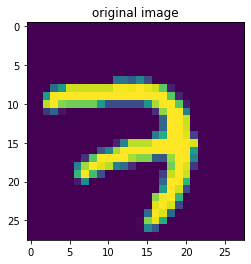

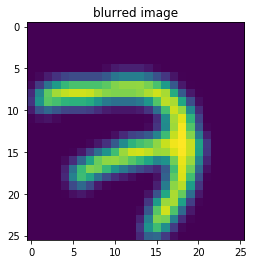

In [ ]:
# a gaussian blur kernel
gaussian_kernel = torch.tensor([[1., 2, 1],[2, 4, 2],[1, 2, 1]]) / 16.0

conv = nn.Conv2d(1, 1, 3)
# manually set the conv weight
conv.weight.data[:] = gaussian_kernel

convolved = conv(image_torch)

plt.title('original image')
plt.imshow(image_torch.view(28,28).detach().numpy())
plt.show()

plt.title('blurred image')
plt.imshow(convolved.view(26,26).detach().numpy())
plt.show()

In [ ]:
im_channels = 3 # if we are working with RGB images, there are 3 input channels, with black and white, 1
out_channels = 16 # this is a hyperparameter we can tune
kernel_size = 3 # this is another hyperparameter we can tune
batch_size = 4
image_width = 32
image_height = 32

im = torch.randn(batch_size, im_channels, image_width, image_height)

m = nn.Conv2d(im_channels, out_channels, kernel_size)
convolved = m(im) # it is a module so we can call it

print('im shape', im.shape)
print('convolved im shape', convolved.shape)

im shape torch.Size([4, 3, 32, 32])
convolved im shape torch.Size([4, 16, 30, 30])


### Learning rate schedulers
可以對 learning rate 的更新方式進行客製化自訂

詳見 [PyTorch 官方文件](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

## Dataset 與 Dataloader
在處理訓練資料時，進行資料型態的前處理與分批（batch）等是相當麻煩的事。  
PyTorch 提供了一個很好的 dataset 與 dataloader 讓我們進行分裝以利訓練進行，還可以依需求自訂 dataset 的型態  

簡言之，`dataset` 是用來做打包與預處理（例如輸入資料路徑自動讀取）；  
`Dataloader` 則是可以將整個資料集（dataset）按照 batch 進行迭代分裝或 shuffle（會得到一個 iterator 以利 for 迴圈讀取）

其中 `dataset` 必須給予 `__len__`（dataset 大小）與`__getitem__`（取得特定 index 的資料）的定義  
（否則會跳出 `NotImplementedError`）

另外 `Dataloader` 可以自訂 `collate_fn` 決定 batch 的分裝方式

以下取自 PyTorch 官方（只節錄需要 demo 的部分）

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# 處理圖片
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


In [ ]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
4 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
5 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
6 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
7 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
8 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
9 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
10 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
11 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
12 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
13 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
14 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
15 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
16 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
17 torch.Size([1, 3, 224, 224]) torch.Size([1, 68, 2])


# 好用的參考連結
- [投影片原始檔案](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML2020/PyTorch_Introduction.slides.html)  
- [60-minute PyTorch Tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)  
- [PyTorch 官方文檔](https://pytorch.org/docs/stable/index.html)  
- [Lecture notes on Auto-Diff](https://courses.cs.washington.edu/courses/cse446/19wi/notes/auto-diff.pdf)

In [ ]:
#@markdown # [補充] 混合精度訓練（Mixed Precision Training）
#@markdown 
#@markdown 可以加速並更有效率的訓練模型，只需稍加改動 code  
#@markdown ### references
#@markdown - https://liangtaiwan.github.io  
#@markdown - https://github.com/NVIDIA/apex

#@markdown ### Run me to install APEX...

%%bash
# echo "Check CUDA Version 9 or newer"
# nvcc --version

# echo
CHECK_APEX=`echo -e "try: import apex\nexcept: print(0)"`
if [[ `python3 -c "$CHECK_APEX"` = "0" ]]; then
    # echo -e "Install APEX..."
    git clone https://github.com/NVIDIA/apex -q
    cd apex
    pip install -q -v --no-cache-dir ./
    rm -rf apex
    # echo "DONE!"
# else
    # echo "APEX installed!";
fi

In [ ]:
#@markdown ```python
#@markdown # Declare model and optimizer as usual, with default (FP32) precision
#@markdown model = torch.nn.Linear(D_in, D_out).cuda()
#@markdown optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
#@markdown 
#@markdown # Allow Amp to perform casts as required by the opt_level
#@markdown model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
#@markdown ...
#@markdown # loss.backward() becomes:
#@markdown with amp.scale_loss(loss, optimizer) as scaled_loss:
#@markdown     scaled_loss.backward()
#@markdown ...
#@markdown ```

import apex.amp as amp

# %%
D_in, D_out = 2000, 100

# Declare model and optimizer as usual, with default (FP32) precision
model = torch.nn.Linear(D_in, D_out).cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# %%
input_data = torch.rand(128, 2000).cuda()
output_ans = torch.rand(128, 100).cuda()

# %%
# Allow Amp to perform casts as required by the opt_level
model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
# ...

criterion = torch.nn.MSELoss()

# %%
for i in range(200):
    output_guess = model(input_data)
    loss = criterion(output_guess, output_ans)
    optimizer.zero_grad()

    # loss.backward() becomes:
    with amp.scale_loss(loss, optimizer) as scaled_loss:
        scaled_loss.backward()

    optimizer.step()
    print(f"Epoch {i + 1:3d}: loss = {loss.item():6.4f}")

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Epoch   1: loss = 0.4835
Epoch   2: loss = 0.4760
Epoch   3: loss = 0.4687
Epoch   4: loss = 0.4616
Epoch   5: loss = 0.4546
Epoch   6: loss = 0.4477
Epoch   7: loss = 0.4409
Epoch   8: loss = 0.4343
Epoch   9: loss = 0.4279
Epoch  10: loss = 0.4215
Epoch  11: loss = 0.4153
Epoch  12: loss = 0.4092
Epoch  13: lo